In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_validate
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, FunctionTransformer

%matplotlib inline

# 1. EDA

## 1-1. 데이터셋 살펴보기

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv("test.csv")
train.head()

,ID,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,641,GP,M,17.0,U,GT3,T,2.0,3.0,other,...,5.0,2.0,2.0,1.0,1.0,2.0,2.0,9.237551,12.231771,13.248906
1,510,GP,NaN,16.0,U,LE3,T,2.0,4.0,other,...,4.0,2.0,2.0,1.0,2.0,5.0,2.0,14.232852,12.243083,13.201829
2,516,GP,F,15.0,U,GT3,NaN,2.0,3.0,other,...,3.0,NaN,NaN,NaN,1.0,NaN,4.0,11.206084,NaN,11.100779
3,306,GP,M,15.0,R,GT3,T,3.0,4.0,NaN,...,5.0,3.0,NaN,1.0,1.0,5.0,2.0,12.202626,11.187831,11.176760
4,124,NaN,F,16.0,U,NaN,T,2.0,2.0,NaN,...,4.0,3.0,4.0,1.0,2.0,2.0,6.0,13.134366,11.210160,11.231368


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454 entries, 0 to 453
Data columns (total 34 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          454 non-null    int64  
 1   school      405 non-null    object 
 2   sex         396 non-null    object 
 3   age         391 non-null    float64
 4   address     403 non-null    object 
 5   famsize     405 non-null    object 
 6   Pstatus     401 non-null    object 
 7   Medu        396 non-null    float64
 8   Fedu        416 non-null    float64
 9   Mjob        399 non-null    object 
 10  Fjob        411 non-null    object 
 11  reason      407 non-null    object 
 12  guardian    413 non-null    object 
 13  traveltime  411 non-null    float64
 14  studytime   405 non-null    float64
 15  failures    407 non-null    float64
 16  schoolsup   407 non-null    object 
 17  famsup      409 non-null    object 
 18  paid        412 non-null    object 
 19  activities  403 non-null    o

In [5]:
object_feature = train.select_dtypes("object")
numeric_feature = train.select_dtypes("float64")

In [5]:
for name in object_feature:
    print(f"unique values of {name} : {np.sort(train[name].dropna().unique())}")

unique values of school : ['GP' 'MS']
unique values of sex : ['F' 'M']
unique values of address : ['R' 'U']
unique values of famsize : ['GT3' 'LE3']
unique values of Pstatus : ['A' 'T']
unique values of Mjob : ['at_home' 'health' 'other' 'services' 'teacher']
unique values of Fjob : ['at_home' 'health' 'other' 'services' 'teacher']
unique values of reason : ['course' 'home' 'other' 'reputation']
unique values of guardian : ['father' 'mother' 'other']
unique values of schoolsup : ['no' 'yes']
unique values of famsup : ['no' 'yes']
unique values of paid : ['no' 'yes']
unique values of activities : ['no' 'yes']
unique values of nursery : ['no' 'yes']
unique values of higher : ['no' 'yes']
unique values of internet : ['no' 'yes']
unique values of romantic : ['no' 'yes']


In [6]:
for name in numeric_feature.columns[(numeric_feature.describe()[-1:] < 10).iloc[0, :].to_numpy()]:
    print(f"unique values of {name} : {np.sort(train[name].dropna().unique())}")

unique values of Medu : [0. 1. 2. 3. 4.]
unique values of Fedu : [0. 1. 2. 3. 4.]
unique values of traveltime : [1. 2. 3. 4.]
unique values of studytime : [1. 2. 3. 4.]
unique values of failures : [0. 1. 2. 3.]
unique values of famrel : [1. 2. 3. 4. 5.]
unique values of freetime : [1. 2. 3. 4. 5.]
unique values of goout : [1. 2. 3. 4. 5.]
unique values of Dalc : [1. 2. 3. 4. 5.]
unique values of Walc : [1. 2. 3. 4. 5.]
unique values of health : [1. 2. 3. 4. 5.]


## 1-2. 연속형 특성의 관계

In [7]:
numeric_feature.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,391.000000,396.000000,416.000000,411.000000,405.000000,407.000000,410.000000,407.000000,421.000000,405.000000,420.000000,405.000000,408.000000,409.000000,410.000000,454.000000
mean,16.723785,2.530303,2.324519,1.542579,1.933333,0.218673,3.868293,3.189189,3.161520,1.540741,2.269048,3.454321,3.723039,11.573324,11.662033,11.992548
std,1.213354,1.154667,1.105506,0.729191,0.828335,0.577787,0.977607,1.074139,1.161912,0.952560,1.266983,1.476218,4.905922,2.696468,2.967221,3.292919
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,5.183922,0.120467,0.102433
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,3.000000,2.500000,2.000000,1.000000,1.000000,2.000000,0.000000,10.122587,10.114836,10.196103
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.216576,11.239625,12.139594
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,4.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.233304,13.216036,14.148699
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.248120,19.102766,19.182714


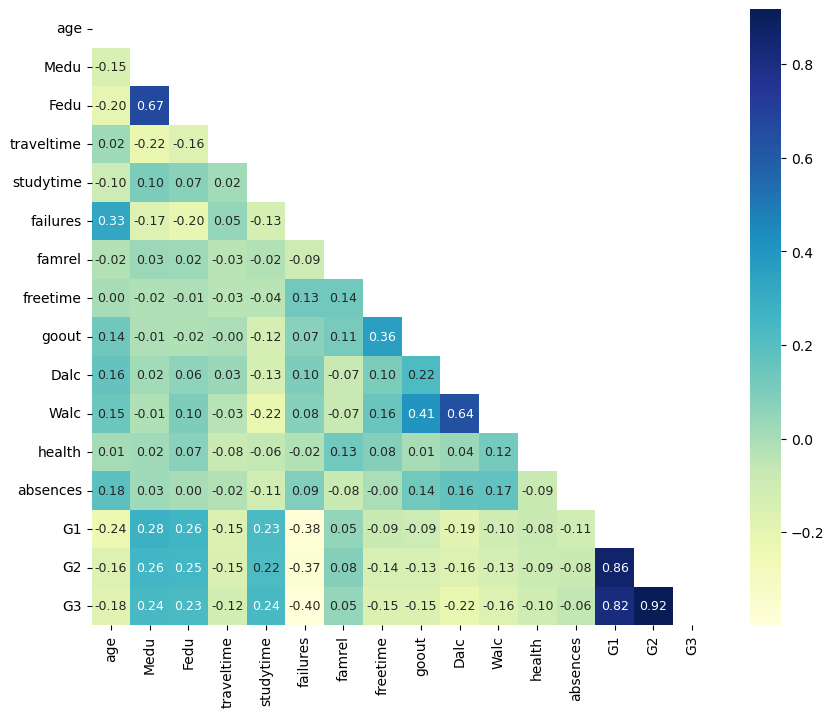

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(numeric_feature.corr(), cmap="YlGnBu", annot=True, fmt=".2f", annot_kws={"size": 9}, mask=np.triu(numeric_feature.corr()), ax=ax)
plt.show()

In [9]:
coor_df = pd.DataFrame(numeric_feature.corr()[(numeric_feature.corr() != 0) & (numeric_feature.corr() != 1)].unstack().sort_values(ascending=False, key=np.abs).drop_duplicates()[:-1], columns=["상관계수"])
coor_df.head(15)

상관계수
G3       G2        0.917332
G2       G1        0.864020
G3       G1        0.815049
Fedu     Medu      0.666163
Walc     Dalc      0.643166
         goout     0.407357
G3       failures -0.399185
G1       failures -0.384373
G2       failures -0.371524
freetime goout     0.361758
failures age       0.329788
G1       Medu      0.280957
         Fedu      0.259429
G2       Medu      0.256376
Fedu     G2        0.251924

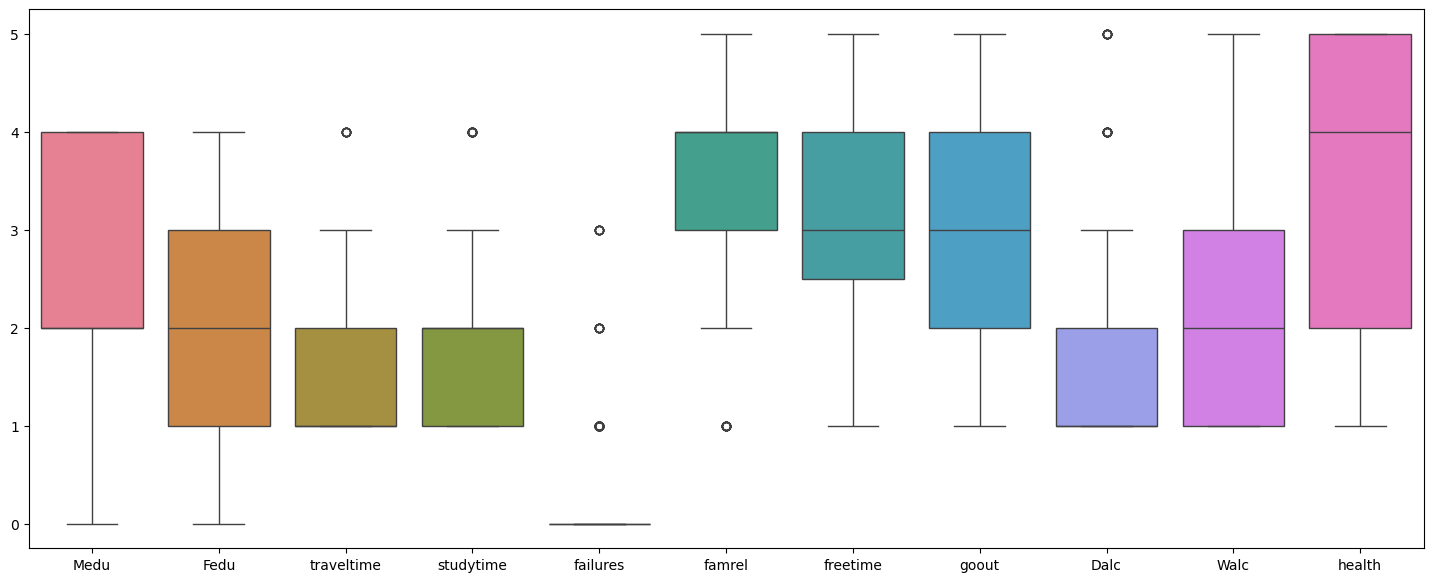

In [10]:
fig, ax = plt.subplots(figsize=(18, 7))
sns.boxplot(numeric_feature[numeric_feature.columns[(numeric_feature.describe()[-1:] < 10).iloc[0, :].to_numpy()]], ax=ax)
plt.show()

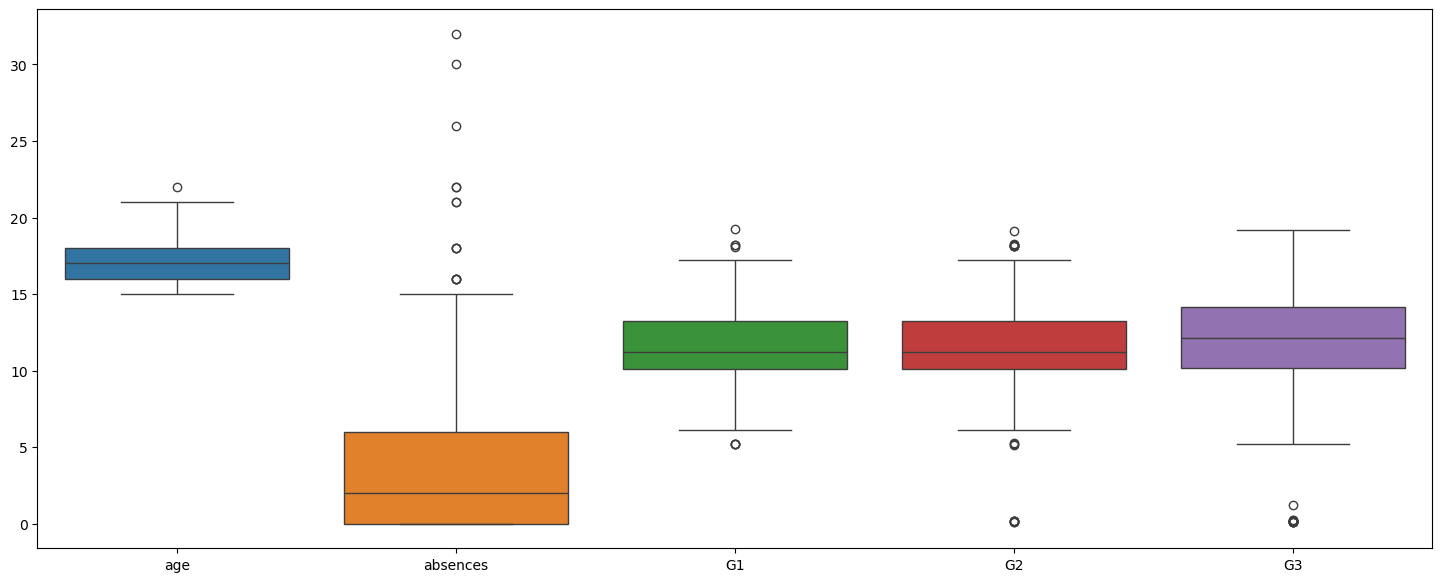

In [11]:
fig, ax = plt.subplots(figsize=(18, 7))
sns.boxplot(numeric_feature[numeric_feature.columns[(numeric_feature.describe()[-1:] >= 10).iloc[0, :].to_numpy()]], ax=ax)
plt.show()

## 1-3. 범주형 특성과 타겟의 관계

In [12]:
object_feature.describe()

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
count,405,396,403,405,401,399,411,407,413,407,409,412,403,409,418,406,411
unique,2,2,2,2,2,5,5,4,3,2,2,2,2,2,2,2,2
top,GP,F,U,GT3,T,other,other,course,mother,no,yes,no,yes,yes,yes,yes,no
freq,277,226,283,289,356,165,231,173,293,365,249,386,202,320,367,313,259


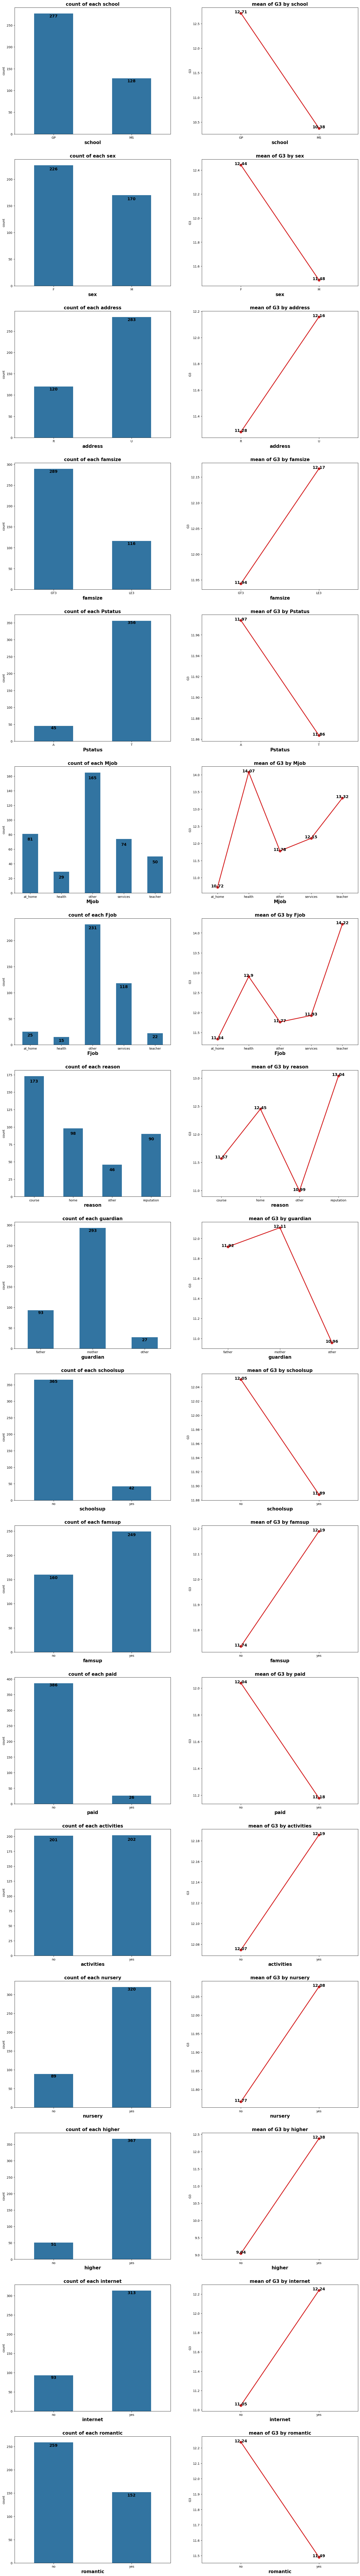

In [13]:
fig, ax = plt.subplots(17, 2, figsize=(20, 150))
for idx, feature in enumerate(object_feature.columns.to_list()):
    sns.countplot(train[object_feature.columns.to_list() + ["G3"]], x=feature, order=np.sort(train[feature].dropna().unique()), width=0.5, ax=ax[idx, 0])
    sns.pointplot(train[object_feature.columns.to_list() + ["G3"]], x=feature, order=np.sort(train[feature].dropna().unique()), y="G3", errorbar=None, color="tab:red", ax=ax[idx, 1])
    ax[idx, 0].set_title(f"count of each {feature}", {"size": 15, "weight": "bold"})
    ax[idx, 0].set_xlabel(feature, {"size": 15, "weight": "bold"})
    ax[idx, 1].set_title(f"mean of G3 by {feature}", {"size": 15, "weight": "bold"})
    ax[idx, 1].set_xlabel(feature, {"size": 15, "weight": "bold"})
    for idx_2, bar in enumerate(ax[idx, 0].patches):
        ax[idx, 0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() - len(train) * 0.02, int(bar.get_height()), horizontalalignment="center", size=13, weight="bold")
        ax[idx, 1].text(bar.get_x() + bar.get_width() / 2, train.groupby(feature).G3.mean().sort_index().iloc[idx_2], train.groupby(feature).G3.mean().sort_index().iloc[idx_2].round(2), horizontalalignment="center", size=13, weight="bold")
plt.show()

## 1-4. 결측치 확인

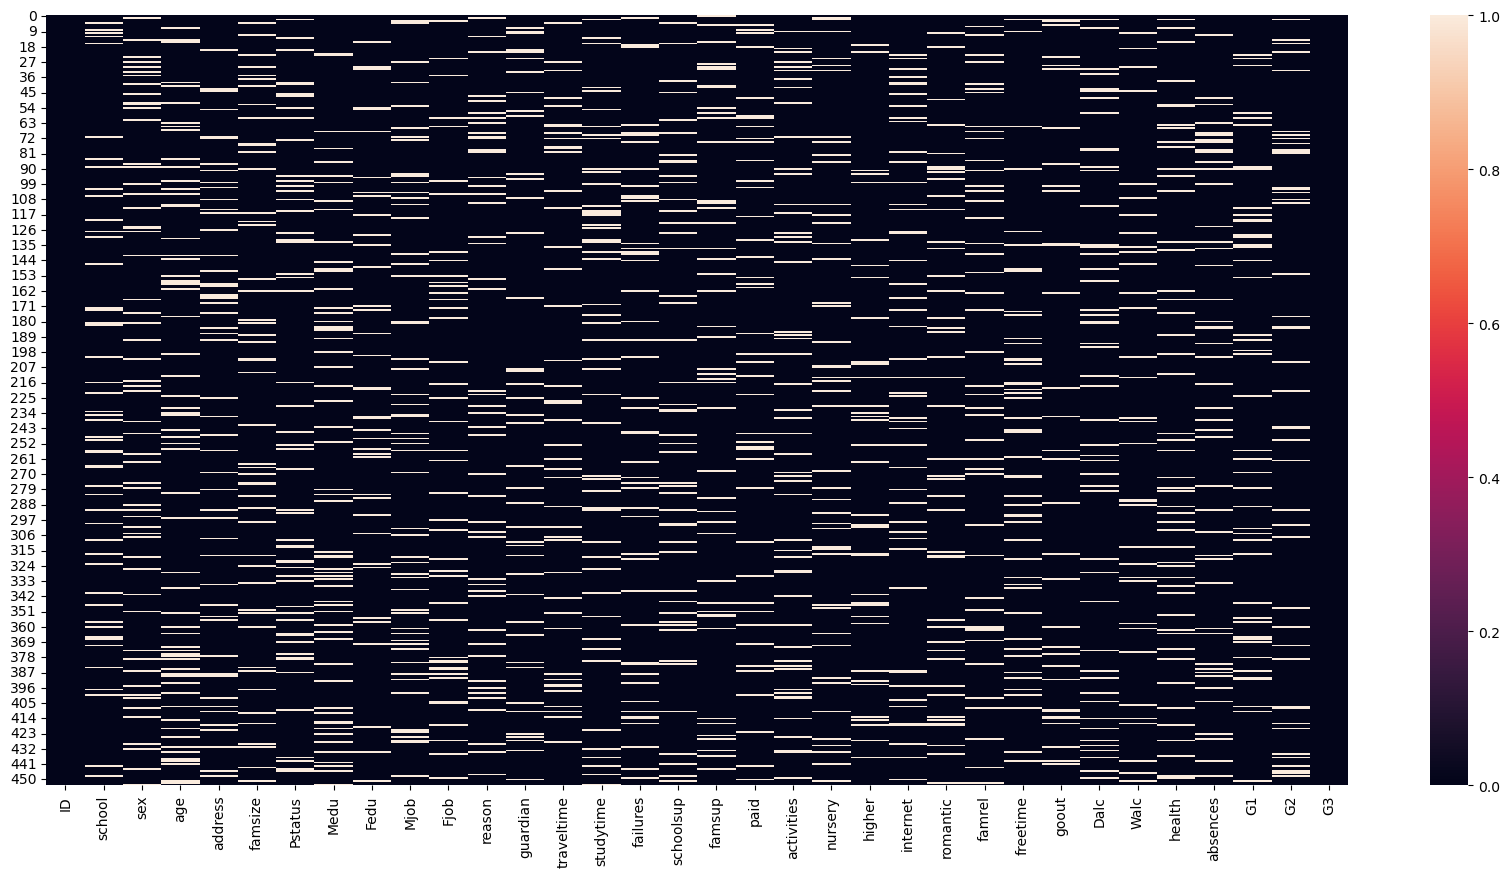

In [14]:
fig, ax = plt.subplots(figsize=(21, 10))
sns.heatmap(train.isna(), ax=ax)
plt.show()

In [15]:
train_na_ratio = train.isna().sum() / len(train) * 100
test_na_ratio = test.isna().sum() / len(test) * 100
sub_ratio = train_na_ratio - test_na_ratio
train_na_ratio.name = "train_na_ratio"
test_na_ratio.name = "test_na_ratio"
sub_ratio.name = "sub_ratio"
df = pd.concat((train_na_ratio, test_na_ratio, sub_ratio), axis=1)
df

,train_na_ratio,test_na_ratio,sub_ratio
ID,0.000000,0.000000,0.000000
school,10.792952,11.282051,-0.489100
sex,12.775330,9.230769,3.544561
age,13.876652,10.256410,3.620242
address,11.233480,8.205128,3.028352
famsize,10.792952,11.282051,-0.489100
Pstatus,11.674009,14.358974,-2.684966
Medu,12.775330,13.333333,-0.558003
Fedu,8.370044,10.769231,-2.399187
Mjob,12.114537,11.282051,0.832486


# 2. 결측치 처리별 파이프라인 구성

In [16]:
X, y = train.iloc[:, :-1], train.G3
nominal_column = X.select_dtypes("object").columns
ordinal_column = X.select_dtypes("float64").columns[X.select_dtypes("float64").max() <= 5].drop("failures")
discrete_column = ["failures", "absences"] # "age" 포함
continuous_column = ["G1", "G2"]
print(f"명목형 : {nominal_column.to_list()}\n순서형 : {ordinal_column.to_list()}\n이산형 : {discrete_column}\n연속형 : {continuous_column}")

명목형 : ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
순서형 : ['Medu', 'Fedu', 'traveltime', 'studytime', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']
이산형 : ['failures', 'absences']
연속형 : ['G1', 'G2']


### 2-1. SimpleImputer

* 명목형 특성의 결측치 : 최빈값 대입 -> one-hot
* 순서형 특성의 결측치 : 최빈값 대입 -> min-max
* 이산형 특성의 결측치 : 최빈값 대입 -> robust
* 연속형 특성의 결측치 : 평균, 중앙값 대입 -> age : round -> robust
* 연속형 특성의 결측치 : 평균, 중앙값 대입 -> G1, G2 : min-max

In [17]:
preprocessing_1 = ColumnTransformer([("nominal", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("one-hot", OneHotEncoder())]), nominal_column), 
                                     ("ordinal", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("min-max", MinMaxScaler())]), ordinal_column), 
                                     ("discrete", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("robust", RobustScaler())]), discrete_column), 
                                     ("age", Pipeline([("mean", SimpleImputer(strategy="mean")), ("round", FunctionTransformer(lambda x: x.round(), feature_names_out="one-to-one")), ("robust", RobustScaler())]), ["age"])], 
                                    remainder=Pipeline([("mean", SimpleImputer(strategy="mean")), ("min-max", FunctionTransformer(lambda x: x / 20, lambda x: x * 20, feature_names_out="one-to-one"))]), n_jobs=-1)

preprocessing_2 = ColumnTransformer([("nominal", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("one-hot", OneHotEncoder())]), nominal_column), 
                                     ("ordinal", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("min-max", MinMaxScaler())]), ordinal_column), 
                                     ("discrete", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("robust", RobustScaler())]), discrete_column), 
                                     ("age", Pipeline([("median", SimpleImputer(strategy="median")), ("round", FunctionTransformer(lambda x: x.round(), feature_names_out="one-to-one")), ("robust", RobustScaler())]), ["age"])], 
                                    remainder=Pipeline([("median", SimpleImputer(strategy="median")), ("min-max", FunctionTransformer(lambda x: x / 20, lambda x: x * 20, feature_names_out="one-to-one"))]), n_jobs=-1)

In [18]:
preprocessing_1

ColumnTransformer(n_jobs=-1,
                  remainder=Pipeline(steps=[('mean', SimpleImputer()),
                                            ('min-max',
                                             FunctionTransformer(feature_names_out='one-to-one',
                                                                 func=<function <lambda> at 0x0000027898B8A4C0>,
                                                                 inverse_func=<function <lambda> at 0x0000027898B8A550>))]),
                  transformers=[('nominal',
                                 Pipeline(steps=[('mode',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('one-hot', OneHotEn...
       'goout', 'Dalc', 'Walc', 'health'],
      dtype='object')),
                                ('discrete',
                                 Pipeline(steps=[('mode',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('robust', RobustScaler())]),
                                 ['failures', 'absences']),
                                ('age',
                                 Pipeline(steps=[('mean', SimpleImputer()),
                                                 ('round',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function <lambda> at 0x0000027898B8A430>)),
                                                 ('robust', RobustScaler())]),
                                 ['age'])])

### 2-2. KNNImputer

* 명목형 특성의 결측치 : 최빈값 -> one-hot
* 순서형 특성의 결측치 : n_neighbors = 3 or 5 -> min-max
* 이산형 특성의 결측치 : n_neighbors = 3 or 5 -> robust
* 연속형 특성의 결측치 : n_neighbors = 3 or 5 -> age : robust
* 연속형 특성의 결측치 : n_neighbors = 3 or 5 -> G1, G2 : min-max

In [19]:
preprocessing_3 = ColumnTransformer([("nominal", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("one-hot", OneHotEncoder())]), nominal_column), 
                                     ("ordinal", Pipeline([("knn_3", KNNImputer(n_neighbors=3)), ("round", FunctionTransformer(lambda x: x.round(), feature_names_out="one-to-one")), ("min-max", MinMaxScaler())]), ordinal_column), 
                                     ("discrete", Pipeline([("knn_3", KNNImputer(n_neighbors=3)), ("round", FunctionTransformer(lambda x: x.round(), feature_names_out="one-to-one")), ("robust", RobustScaler())]), discrete_column), 
                                     ("age", Pipeline([("knn_3", KNNImputer(n_neighbors=3)), ("round", FunctionTransformer(lambda x: x.round(), feature_names_out="one-to-one")), ("robust", RobustScaler())]), ["age"])], 
                                    remainder=Pipeline([("knn_3", KNNImputer(n_neighbors=3)), ("min-max", FunctionTransformer(lambda x: x / 20, lambda x: x * 20, feature_names_out="one-to-one"))]), n_jobs=-1)

preprocessing_4 = ColumnTransformer([("nominal", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("one-hot", OneHotEncoder())]), nominal_column), 
                                     ("ordinal", Pipeline([("knn_5", KNNImputer(n_neighbors=5)), ("round", FunctionTransformer(lambda x: x.round(), feature_names_out="one-to-one")), ("min-max", MinMaxScaler())]), ordinal_column), 
                                     ("discrete", Pipeline([("knn_5", KNNImputer(n_neighbors=5)), ("round", FunctionTransformer(lambda x: x.round(), feature_names_out="one-to-one")), ("robust", RobustScaler())]), discrete_column), 
                                     ("age", Pipeline([("knn_5", KNNImputer(n_neighbors=5)), ("round", FunctionTransformer(lambda x: x.round(), feature_names_out="one-to-one")), ("robust", RobustScaler())]), ["age"])], 
                                    remainder=Pipeline([("knn_5", KNNImputer(n_neighbors=5)), ("min-max", FunctionTransformer(lambda x: x / 20, lambda x: x * 20, feature_names_out="one-to-one"))]), n_jobs=-1)

In [20]:
preprocessing_3

ColumnTransformer(n_jobs=-1,
                  remainder=Pipeline(steps=[('knn_3',
                                             KNNImputer(n_neighbors=3)),
                                            ('min-max',
                                             FunctionTransformer(feature_names_out='one-to-one',
                                                                 func=<function <lambda> at 0x0000027898B8C700>,
                                                                 inverse_func=<function <lambda> at 0x0000027898B8C790>))]),
                  transformers=[('nominal',
                                 Pipeline(steps=[('mode',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('one-ho...
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function <lambda> at 0x0000027898B8C5E0>)),
                                                 ('robust', RobustScaler())]),
                                 ['failures', 'absences']),
                                ('age',
                                 Pipeline(steps=[('knn_3',
                                                  KNNImputer(n_neighbors=3)),
                                                 ('round',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function <lambda> at 0x0000027898B8C670>)),
                                                 ('robust', RobustScaler())]),
                                 ['age'])])

### 2-3. IterativeImputer

* 명목형 특성의 결측치 : 최빈값 -> one-hot
* 순서형 특성의 결측치 : Logistic ("lbfgs", "liblinear") -> min-max
* 이산형 특성의 결측치 : Logistic ("lbfgs", "liblinear") -> robust
* 연속형 특성의 결측치 : Logistic -> age : robust
* 연속형 특성의 결측치 : Linear -> G1, G2 : min-max

* lbfgs : 2차 도함수를 정확하게 계산하는 것이 아니라 근사치를 사용하여 속도를 개선
* liblinear : 한 번에 하나의 파라미터만 업데이트

In [21]:
preprocessing_5 = ColumnTransformer([("nominal", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("one-hot", OneHotEncoder())]), nominal_column), 
                                     ("ordinal", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("min-max", MinMaxScaler())]), ordinal_column), 
                                     ("discrete", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("robust", RobustScaler())]), discrete_column), 
                                     ("age", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("robust", RobustScaler())]), ["age"])], 
                                    remainder=Pipeline([("iterative", IterativeImputer(estimator=LinearRegression(n_jobs=-1), random_state=1396)), ("min-max", FunctionTransformer(lambda x: x / 20, lambda x: x * 20, feature_names_out="one-to-one"))]), n_jobs=-1)

preprocessing_6 = ColumnTransformer([("nominal", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("one-hot", OneHotEncoder())]), nominal_column), 
                                     ("ordinal", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(random_state=1396, solver="liblinear", n_jobs=-1), random_state=1396)), ("min-max", MinMaxScaler())]), ordinal_column), 
                                     ("discrete", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(random_state=1396, solver="liblinear", n_jobs=-1), random_state=1396)), ("robust", RobustScaler())]), discrete_column), 
                                     ("age", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(random_state=1396, solver="liblinear", n_jobs=-1), random_state=1396)), ("robust", RobustScaler())]), ["age"])], 
                                    remainder=Pipeline([("iterative", IterativeImputer(estimator=LinearRegression(n_jobs=-1), random_state=1396)), ("min-max", FunctionTransformer(lambda x: x / 20, lambda x: x * 20, feature_names_out="one-to-one"))]), n_jobs=-1)

In [22]:
preprocessing_5

ColumnTransformer(n_jobs=-1,
                  remainder=Pipeline(steps=[('iterative',
                                             IterativeImputer(estimator=LinearRegression(n_jobs=-1),
                                                              random_state=1396)),
                                            ('min-max',
                                             FunctionTransformer(feature_names_out='one-to-one',
                                                                 func=<function <lambda> at 0x0000027898B8CEE0>,
                                                                 inverse_func=<function <lambda> at 0x0000027898B8AA60>))]),
                  transformers=[('nominal',
                                 Pipeline(steps=[('mod...
       'goout', 'Dalc', 'Walc', 'health'],
      dtype='object')),
                                ('discrete',
                                 Pipeline(steps=[('iterative',
                                                  IterativeImputer(estimator=LogisticRegression(n_jobs=-1),
                                                                   random_state=1396)),
                                                 ('robust', RobustScaler())]),
                                 ['failures', 'absences']),
                                ('age',
                                 Pipeline(steps=[('iterative',
                                                  IterativeImputer(estimator=LogisticRegression(n_jobs=-1),
                                                                   random_state=1396)),
                                                 ('robust', RobustScaler())]),
                                 ['age'])])

In [23]:
print(f"preprocessing_1 nan value : {pd.DataFrame(preprocessing_1.fit_transform(train.iloc[:, :-1])).isna().sum().sum()}")
print(f"preprocessing_2 nan value : {pd.DataFrame(preprocessing_2.fit_transform(train.iloc[:, :-1])).isna().sum().sum()}")
print(f"preprocessing_3 nan value : {pd.DataFrame(preprocessing_3.fit_transform(train.iloc[:, :-1])).isna().sum().sum()}")
print(f"preprocessing_4 nan value : {pd.DataFrame(preprocessing_4.fit_transform(train.iloc[:, :-1])).isna().sum().sum()}")
print(f"preprocessing_5 nan value : {pd.DataFrame(preprocessing_5.fit_transform(train.iloc[:, :-1])).isna().sum().sum()}")
print(f"preprocessing_6 nan value : {pd.DataFrame(preprocessing_6.fit_transform(train.iloc[:, :-1])).isna().sum().sum()}")

preprocessing_1 nan value : 0
preprocessing_2 nan value : 0
preprocessing_3 nan value : 0
preprocessing_4 nan value : 0
preprocessing_5 nan value : 0
preprocessing_6 nan value : 0


In [24]:
preprocessing_1 = ColumnTransformer([("nominal", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("one-hot", OneHotEncoder())]), nominal_column), 
                                     ("ordinal", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("min-max", MinMaxScaler())]), ordinal_column), 
                                     ("discrete", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("robust", RobustScaler())]), discrete_column), 
                                     ("age", Pipeline([("mean", SimpleImputer(strategy="mean")), ("round", FunctionTransformer(lambda x: x.round(), feature_names_out="one-to-one")), ("robust", RobustScaler())]), ["age"])], 
                                    remainder=Pipeline([("mean", SimpleImputer(strategy="mean")), ("min-max", FunctionTransformer(lambda x: x / 20, lambda x: x * 20, feature_names_out="one-to-one"))]), n_jobs=-1)

preprocessing_2 = ColumnTransformer([("nominal", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("one-hot", OneHotEncoder())]), nominal_column), 
                                     ("ordinal", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("min-max", MinMaxScaler())]), ordinal_column), 
                                     ("discrete", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("robust", RobustScaler())]), discrete_column), 
                                     ("age", Pipeline([("median", SimpleImputer(strategy="median")), ("round", FunctionTransformer(lambda x: x.round(), feature_names_out="one-to-one")), ("robust", RobustScaler())]), ["age"])], 
                                    remainder=Pipeline([("median", SimpleImputer(strategy="median")), ("min-max", FunctionTransformer(lambda x: x / 20, lambda x: x * 20, feature_names_out="one-to-one"))]), n_jobs=-1)

preprocessing_3 = ColumnTransformer([("nominal", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("one-hot", OneHotEncoder())]), nominal_column), 
                                     ("ordinal", Pipeline([("knn_3", KNNImputer(n_neighbors=3)), ("round", FunctionTransformer(lambda x: x.round(), feature_names_out="one-to-one")), ("min-max", MinMaxScaler())]), ordinal_column), 
                                     ("discrete", Pipeline([("knn_3", KNNImputer(n_neighbors=3)), ("round", FunctionTransformer(lambda x: x.round(), feature_names_out="one-to-one")), ("robust", RobustScaler())]), discrete_column), 
                                     ("age", Pipeline([("knn_3", KNNImputer(n_neighbors=3)), ("round", FunctionTransformer(lambda x: x.round(), feature_names_out="one-to-one")), ("robust", RobustScaler())]), ["age"])], 
                                    remainder=Pipeline([("knn_3", KNNImputer(n_neighbors=3)), ("min-max", FunctionTransformer(lambda x: x / 20, lambda x: x * 20, feature_names_out="one-to-one"))]), n_jobs=-1)

preprocessing_4 = ColumnTransformer([("nominal", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("one-hot", OneHotEncoder())]), nominal_column), 
                                     ("ordinal", Pipeline([("knn_5", KNNImputer(n_neighbors=5)), ("round", FunctionTransformer(lambda x: x.round(), feature_names_out="one-to-one")), ("min-max", MinMaxScaler())]), ordinal_column), 
                                     ("discrete", Pipeline([("knn_5", KNNImputer(n_neighbors=5)), ("round", FunctionTransformer(lambda x: x.round(), feature_names_out="one-to-one")), ("robust", RobustScaler())]), discrete_column), 
                                     ("age", Pipeline([("knn_5", KNNImputer(n_neighbors=5)), ("round", FunctionTransformer(lambda x: x.round(), feature_names_out="one-to-one")), ("robust", RobustScaler())]), ["age"])], 
                                    remainder=Pipeline([("knn_5", KNNImputer(n_neighbors=5)), ("min-max", FunctionTransformer(lambda x: x / 20, lambda x: x * 20, feature_names_out="one-to-one"))]), n_jobs=-1)

preprocessing_5 = ColumnTransformer([("nominal", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("one-hot", OneHotEncoder())]), nominal_column), 
                                     ("ordinal", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("min-max", MinMaxScaler())]), ordinal_column), 
                                     ("discrete", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("robust", RobustScaler())]), discrete_column), 
                                     ("age", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("robust", RobustScaler())]), ["age"])], 
                                    remainder=Pipeline([("iterative", IterativeImputer(estimator=LinearRegression(n_jobs=-1), random_state=1396)), ("min-max", FunctionTransformer(lambda x: x / 20, lambda x: x * 20, feature_names_out="one-to-one"))]), n_jobs=-1)

preprocessing_6 = ColumnTransformer([("nominal", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("one-hot", OneHotEncoder())]), nominal_column), 
                                     ("ordinal", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(random_state=1396, solver="liblinear", n_jobs=-1), random_state=1396)), ("min-max", MinMaxScaler())]), ordinal_column), 
                                     ("discrete", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(random_state=1396, solver="liblinear", n_jobs=-1), random_state=1396)), ("robust", RobustScaler())]), discrete_column), 
                                     ("age", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(random_state=1396, solver="liblinear", n_jobs=-1), random_state=1396)), ("robust", RobustScaler())]), ["age"])], 
                                    remainder=Pipeline([("iterative", IterativeImputer(estimator=LinearRegression(n_jobs=-1), random_state=1396)), ("min-max", FunctionTransformer(lambda x: x / 20, lambda x: x * 20, feature_names_out="one-to-one"))]), n_jobs=-1)

# 3. 모델링

In [25]:
model_1 = Pipeline([("preprocessing", preprocessing_1), ("model", TransformedTargetRegressor(regressor=LinearRegression(n_jobs=-1), func=lambda x: x / 20, inverse_func=lambda x: x * 20))])
model_2 = Pipeline([("preprocessing", preprocessing_2), ("model", TransformedTargetRegressor(regressor=LinearRegression(n_jobs=-1), func=lambda x: x / 20, inverse_func=lambda x: x * 20))])
model_3 = Pipeline([("preprocessing", preprocessing_3), ("model", TransformedTargetRegressor(regressor=LinearRegression(n_jobs=-1), func=lambda x: x / 20, inverse_func=lambda x: x * 20))])
model_4 = Pipeline([("preprocessing", preprocessing_4), ("model", TransformedTargetRegressor(regressor=LinearRegression(n_jobs=-1), func=lambda x: x / 20, inverse_func=lambda x: x * 20))])
model_5 = Pipeline([("preprocessing", preprocessing_5), ("model", TransformedTargetRegressor(regressor=LinearRegression(n_jobs=-1), func=lambda x: x / 20, inverse_func=lambda x: x * 20))])
model_6 = Pipeline([("preprocessing", preprocessing_6), ("model", TransformedTargetRegressor(regressor=LinearRegression(n_jobs=-1), func=lambda x: x / 20, inverse_func=lambda x: x * 20))])
model_6

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1,
                                   remainder=Pipeline(steps=[('iterative',
                                                              IterativeImputer(estimator=LinearRegression(n_jobs=-1),
                                                                               random_state=1396)),
                                                             ('min-max',
                                                              FunctionTransformer(feature_names_out='one-to-one',
                                                                                  func=<function <lambda> at 0x0000027898BE8820>,
                                                                                  inverse_func=<function <lambda> at 0x0000027898BE8B80>))]),
                                   transformers=...
                                                  Pipeline(steps=[('iterative',
                                                                   IterativeImputer(estimator=LogisticRegression(n_jobs=-1,
                                                                                                                 random_state=1396,
                                                                                                                 solver='liblinear'),
                                                                                    random_state=1396)),
                                                                  ('robust',
                                                                   RobustScaler())]),
                                                  ['age'])])),
                ('model',
                 TransformedTargetRegressor(func=<function <lambda> at 0x0000027898C0EF70>,
                                            inverse_func=<function <lambda> at 0x0000027898C32040>,
                                            regressor=LinearRegression(n_jobs=-1)))])

In [26]:
for model_num, model in enumerate([model_1, model_2, model_3, model_4, model_5, model_6], 1):
    R2 = cross_validate(model, X, y, n_jobs=-1, return_train_score=True)
    RMSE = cross_validate(model, X, y, scoring="neg_root_mean_squared_error", n_jobs=-1, return_train_score=True)
    print(f"model_{model_num} R2   / train : {R2.get('train_score').mean():>4.4f} / test : {R2.get('test_score').mean():>4.4f} / sub : {R2.get('train_score').mean() - R2.get('test_score').mean():>4.4f}")
    print(f"model_{model_num} RMSE / train : {-RMSE.get('train_score').mean():>4.4f} / test : {-RMSE.get('test_score').mean():>4.4f} / sub : {RMSE.get('train_score').mean() - RMSE.get('test_score').mean():>4.4f}")
    print("=============================================")

model_1 R2   / train : 0.8236 / test : 0.7711 / sub : 0.0525
model_1 RMSE / train : 1.3794 / test : 1.5649 / sub : 0.1855
model_2 R2   / train : 0.8228 / test : 0.7715 / sub : 0.0514
model_2 RMSE / train : 1.3824 / test : 1.5633 / sub : 0.1808
model_3 R2   / train : 0.8255 / test : 0.7821 / sub : 0.0434
model_3 RMSE / train : 1.3719 / test : 1.5254 / sub : 0.1535
model_4 R2   / train : 0.8245 / test : 0.7780 / sub : 0.0465
model_4 RMSE / train : 1.3757 / test : 1.5415 / sub : 0.1657
model_5 R2   / train : 0.8582 / test : 0.8221 / sub : 0.0361
model_5 RMSE / train : 1.2366 / test : 1.3731 / sub : 0.1364
model_6 R2   / train : 0.8583 / test : 0.8217 / sub : 0.0366
model_6 RMSE / train : 1.2363 / test : 1.3750 / sub : 0.1387


In [27]:
model_5.fit(X, y)
coef = np.append(model_5.named_steps.get("model").regressor_.coef_, model_5.named_steps.get("model").regressor_.intercept_)
index = np.append(model_5.named_steps.get("preprocessing").get_feature_names_out(), "intercept")
pd.DataFrame(coef.round(3), index, ["coef"]).sort_values(by="coef", ascending=False, key=abs).head(10)

,coef
remainder__G2,0.935
intercept,0.045
remainder__G1,0.039
ordinal__Dalc,-0.023
discrete__failures,-0.021
nominal__guardian_other,0.020
nominal__Fjob_at_home,0.020
ordinal__Medu,-0.018
ordinal__studytime,0.016
nominal__Fjob_health,-0.015


# 4. 특성선택과 특성공학

In [28]:
sorted([(feature, train.groupby(feature).G3.mean().sort_index().iloc[0] - train.groupby(feature).G3.mean().sort_index().iloc[1], ) for feature in object_feature.columns.to_list() if len(train.groupby(feature).G3.mean()) == 2], key=lambda x: abs(x[1]))

[('Pstatus', 0.11029041764101244),
 ('activities', -0.1111122605879018),
 ('schoolsup', 0.16278911940874075),
 ('famsize', -0.22361560992348828),
 ('nursery', -0.30933463527724747),
 ('famsup', -0.4534423354407373),
 ('romantic', 0.7466544691803989),
 ('paid', 0.8593484360637689),
 ('address', -0.876888150157038),
 ('sex', 0.9569447058522123),
 ('internet', -1.1916787049129134),
 ('school', 2.335260315380273),
 ('higher', -3.341770774465351)]

In [29]:
nominal_column_2 = X.select_dtypes("object").columns.drop(["Pstatus", "activities", "schoolsup", "famsize", "nursery"])

preprocessing_7 = ColumnTransformer([("nominal", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("one-hot", OneHotEncoder())]), nominal_column_2), 
                                     ("ordinal", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("min-max", MinMaxScaler())]), ordinal_column), 
                                     ("discrete", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("robust", RobustScaler())]), discrete_column), 
                                     ("age", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("robust", RobustScaler())]), ["age"]), 
                                     ("G1, G2", Pipeline([("iterative", IterativeImputer(estimator=LinearRegression(n_jobs=-1), random_state=1396)), ("min-max", FunctionTransformer(lambda x: x / 20, lambda x: x * 20, feature_names_out="one-to-one"))]), ["G1", "G2"])], 
                                    n_jobs=-1)

model_7 = Pipeline([("preprocessing", preprocessing_7), ("model", TransformedTargetRegressor(regressor=LinearRegression(n_jobs=-1), func=lambda x: x / 20, inverse_func=lambda x: x * 20))])
model_7

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('nominal',
                                                  Pipeline(steps=[('mode',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder())]),
                                                  Index(['school', 'sex', 'address', 'Mjob', 'Fjob', 'reason', 'guardian',
       'famsup', 'paid', 'higher', 'internet', 'romantic'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('iterative...
                                                                  ('min-max',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function <lambda> at 0x0000027898C7D670>,
                                                                                       inverse_func=<function <lambda> at 0x0000027898C7DEE0>))]),
                                                  ['G1', 'G2'])])),
                ('model',
                 TransformedTargetRegressor(func=<function <lambda> at 0x0000027898CF3040>,
                                            inverse_func=<function <lambda> at 0x0000027898CF30D0>,
                                            regressor=LinearRegression(n_jobs=-1)))])

In [30]:
for m, n in zip([model_5, model_7], [5, 7]):
    R2 = cross_validate(m, X, y, n_jobs=-1, return_train_score=True)
    RMSE = cross_validate(m, X, y, scoring="neg_root_mean_squared_error", n_jobs=-1, return_train_score=True)
    print(f"model_{n} R2   / train : {R2.get('train_score').mean():>4.4f} / test : {R2.get('test_score').mean():>4.4f} / sub : {R2.get('train_score').mean() - R2.get('test_score').mean():>4.4f}")
    print(f"model_{n} RMSE / train : {-RMSE.get('train_score').mean():>4.4f} / test : {-RMSE.get('test_score').mean():>4.4f} / sub : {RMSE.get('train_score').mean() - RMSE.get('test_score').mean():>4.4f}")
    print("=============================================")

model_5 R2   / train : 0.8582 / test : 0.8221 / sub : 0.0361
model_5 RMSE / train : 1.2366 / test : 1.3731 / sub : 0.1364
model_7 R2   / train : 0.8549 / test : 0.8291 / sub : 0.0258
model_7 RMSE / train : 1.2506 / test : 1.3479 / sub : 0.0973


In [31]:
nominal_column_3 = X.select_dtypes("object").columns.drop(["Pstatus", "activities", "schoolsup", "famsize", "nursery", "guardian"])
preprocessing_8 = ColumnTransformer([("nominal", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("one-hot", OneHotEncoder())]), nominal_column_3), 
                                     ("guardian", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("binary", FunctionTransformer(lambda x: np.where(x == "other", x, "parent"), feature_names_out="one-to-one")), ("one-hot", OneHotEncoder())]), ["guardian"]), 
                                     ("ordinal", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("min-max", MinMaxScaler())]), ordinal_column), 
                                     ("discrete", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("robust", RobustScaler())]), discrete_column), 
                                     ("age", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("robust", RobustScaler())]), ["age"]), 
                                     ("G1, G2", Pipeline([("iterative", IterativeImputer(estimator=LinearRegression(n_jobs=-1), random_state=1396)), ("min-max", FunctionTransformer(lambda x: x / 20, lambda x: x * 20, feature_names_out="one-to-one"))]), ["G1", "G2"])], 
                                    n_jobs=-1)

model_8 = Pipeline([("preprocessing", preprocessing_8), ("model", TransformedTargetRegressor(regressor=LinearRegression(n_jobs=-1), func=lambda x: x / 20, inverse_func=lambda x: x * 20))])
model_8

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('nominal',
                                                  Pipeline(steps=[('mode',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder())]),
                                                  Index(['school', 'sex', 'address', 'Mjob', 'Fjob', 'reason', 'famsup', 'paid',
       'higher', 'internet', 'romantic'],
      dtype='object')),
                                                 ('guardian',
                                                  Pipeline(steps=[('mode',
                                                                   SimpleImputer...
                                                                  ('min-max',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function <lambda> at 0x0000027898CF3EE0>,
                                                                                       inverse_func=<function <lambda> at 0x0000027898CF3CA0>))]),
                                                  ['G1', 'G2'])])),
                ('model',
                 TransformedTargetRegressor(func=<function <lambda> at 0x0000027898CF3DC0>,
                                            inverse_func=<function <lambda> at 0x0000027898D1A0D0>,
                                            regressor=LinearRegression(n_jobs=-1)))])

In [32]:
for m, n in zip([model_5, model_7, model_8], [5, 7, 8]):
    R2 = cross_validate(m, X, y, n_jobs=-1, return_train_score=True)
    RMSE = cross_validate(m, X, y, scoring="neg_root_mean_squared_error", n_jobs=-1, return_train_score=True)
    print(f"model_{n} R2   / train : {R2.get('train_score').mean():>4.4f} / test : {R2.get('test_score').mean():>4.4f} / sub : {R2.get('train_score').mean() - R2.get('test_score').mean():>4.4f}")
    print(f"model_{n} RMSE / train : {-RMSE.get('train_score').mean():>4.4f} / test : {-RMSE.get('test_score').mean():>4.4f} / sub : {RMSE.get('train_score').mean() - RMSE.get('test_score').mean():>4.4f}")
    print("=============================================")

model_5 R2   / train : 0.8582 / test : 0.8221 / sub : 0.0361
model_5 RMSE / train : 1.2366 / test : 1.3731 / sub : 0.1364
model_7 R2   / train : 0.8549 / test : 0.8291 / sub : 0.0258
model_7 RMSE / train : 1.2506 / test : 1.3479 / sub : 0.0973
model_8 R2   / train : 0.8552 / test : 0.8335 / sub : 0.0216
model_8 RMSE / train : 1.2496 / test : 1.3288 / sub : 0.0791


In [33]:
class Pjob(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None, sample_weight=None):
        return self

    def transform(self, X):
        mjob = np.vectorize(lambda x: 1 if x == "at_home" else 2 if x == "other" else 3 if x == "services" else 4 if x == "teacher" else 5 if x == "health" else x, otypes=[np.float64])(X[:, 0])
        fjob = np.vectorize(lambda x: 1 if x == "at_home" else 2 if x == "other" else 3 if x == "services" else 4 if x == "teacher" else 5 if x == "health" else x, otypes=[np.float64])(X[:, 1])
        return np.concatenate((mjob.reshape(-1, 1), fjob.reshape(-1, 1)), axis=1).mean(axis=1).reshape(-1, 1)

    def get_feature_names_out(self, names=None):
        return np.array(["Pjob"], dtype=object)

nominal_column_4 = X.select_dtypes("object").columns.drop(["Pstatus", "activities", "schoolsup", "famsize", "nursery", "guardian", "Mjob", "Fjob"])
preprocessing_9 = ColumnTransformer([("nominal", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("one-hot", OneHotEncoder())]), nominal_column_4), 
                                     ("guardian", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("binary", FunctionTransformer(lambda x: np.where(x == "other", x, "parent"), feature_names_out="one-to-one")), ("one-hot", OneHotEncoder())]), ["guardian"]), 
                                     ("parentjob", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("binary", Pjob()), ("min-max", FunctionTransformer(lambda x: x / 5, lambda x: x * 5, feature_names_out="one-to-one"))]), ["Mjob", "Fjob"]), 
                                     ("ordinal", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("min-max", MinMaxScaler())]), ordinal_column), 
                                     ("discrete", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("robust", RobustScaler())]), discrete_column), 
                                     ("age", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("robust", RobustScaler())]), ["age"]), 
                                     ("G1, G2", Pipeline([("iterative", IterativeImputer(estimator=LinearRegression(n_jobs=-1), random_state=1396)), ("min-max", FunctionTransformer(lambda x: x / 20, lambda x: x * 20, feature_names_out="one-to-one"))]), ["G1", "G2"])], 
                                    n_jobs=-1)

model_9 = Pipeline([("preprocessing", preprocessing_9), ("model", TransformedTargetRegressor(regressor=LinearRegression(n_jobs=-1), func=lambda x: x / 20, inverse_func=lambda x: x * 20))])
model_9

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('nominal',
                                                  Pipeline(steps=[('mode',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder())]),
                                                  Index(['school', 'sex', 'address', 'reason', 'famsup', 'paid', 'higher',
       'internet', 'romantic'],
      dtype='object')),
                                                 ('guardian',
                                                  Pipeline(steps=[('mode',
                                                                   SimpleImputer(strategy='mos...
                                                                  ('min-max',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function <lambda> at 0x0000027898D1AE50>,
                                                                                       inverse_func=<function <lambda> at 0x0000027898D1AEE0>))]),
                                                  ['G1', 'G2'])])),
                ('model',
                 TransformedTargetRegressor(func=<function <lambda> at 0x0000027898D1AF70>,
                                            inverse_func=<function <lambda> at 0x000002789A432040>,
                                            regressor=LinearRegression(n_jobs=-1)))])

In [34]:
for m, n in zip([model_5, model_7, model_8, model_9], [5, 7, 8, 9]):
    R2 = cross_validate(m, X, y, n_jobs=-1, return_train_score=True)
    RMSE = cross_validate(m, X, y, scoring="neg_root_mean_squared_error", n_jobs=-1, return_train_score=True)
    print(f"model_{n} R2   / train : {R2.get('train_score').mean():>4.4f} / test : {R2.get('test_score').mean():>4.4f} / sub : {R2.get('train_score').mean() - R2.get('test_score').mean():>4.4f}")
    print(f"model_{n} RMSE / train : {-RMSE.get('train_score').mean():>4.4f} / test : {-RMSE.get('test_score').mean():>4.4f} / sub : {RMSE.get('train_score').mean() - RMSE.get('test_score').mean():>4.4f}")
    print("=============================================")

model_5 R2   / train : 0.8582 / test : 0.8221 / sub : 0.0361
model_5 RMSE / train : 1.2366 / test : 1.3731 / sub : 0.1364
model_7 R2   / train : 0.8549 / test : 0.8291 / sub : 0.0258
model_7 RMSE / train : 1.2506 / test : 1.3479 / sub : 0.0973
model_8 R2   / train : 0.8552 / test : 0.8335 / sub : 0.0216
model_8 RMSE / train : 1.2496 / test : 1.3288 / sub : 0.0791
model_9 R2   / train : 0.8525 / test : 0.8341 / sub : 0.0183
model_9 RMSE / train : 1.2614 / test : 1.3257 / sub : 0.0643


In [35]:
class WeekAlc(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.mean(axis=1).round().reshape(-1, 1)

    def get_feature_names_out(self, names=None):
        return np.array(["WeekAlc"], dtype=object)

ordinal_column_2 = X.select_dtypes("float64").columns[X.select_dtypes("float64").max() <= 5].drop(["Walc", "Dalc"])
preprocessing_10 = ColumnTransformer([("nominal", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("one-hot", OneHotEncoder())]), nominal_column_4), 
                                      ("guardian", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("binary", FunctionTransformer(lambda x: np.where(x == "other", x, "parent"), feature_names_out="one-to-one")), ("one-hot", OneHotEncoder())]), ["guardian"]), 
                                      ("parentjob", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("binary", Pjob()), ("min-max", FunctionTransformer(lambda x: x / 5, lambda x: x * 5, feature_names_out="one-to-one"))]), ["Mjob", "Fjob"]), 
                                      ("ordinal", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("min-max", MinMaxScaler())]), ordinal_column_2), 
                                      ("Walc, Dalc", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("WeekAlc", WeekAlc()), ("min-max", FunctionTransformer(lambda x: x / 5, lambda x: x * 5, feature_names_out="one-to-one"))]), ["Walc", "Dalc"]), 
                                      ("discrete", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("robust", RobustScaler())]), discrete_column), 
                                      ("age", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("robust", RobustScaler())]), ["age"]), 
                                      ("G1, G2", Pipeline([("iterative", IterativeImputer(estimator=LinearRegression(n_jobs=-1), random_state=1396)), ("min-max", FunctionTransformer(lambda x: x / 20, lambda x: x * 20, feature_names_out="one-to-one"))]), ["G1", "G2"])], 
                                     n_jobs=-1)

model_10 = Pipeline([("preprocessing", preprocessing_10), ("model", TransformedTargetRegressor(regressor=LinearRegression(n_jobs=-1), func=lambda x: x / 20, inverse_func=lambda x: x * 20))])
model_10

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('nominal',
                                                  Pipeline(steps=[('mode',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder())]),
                                                  Index(['school', 'sex', 'address', 'reason', 'famsup', 'paid', 'higher',
       'internet', 'romantic'],
      dtype='object')),
                                                 ('guardian',
                                                  Pipeline(steps=[('mode',
                                                                   SimpleImputer(strategy='mos...
                                                                  ('min-max',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function <lambda> at 0x000002789A438700>,
                                                                                       inverse_func=<function <lambda> at 0x000002789A438790>))]),
                                                  ['G1', 'G2'])])),
                ('model',
                 TransformedTargetRegressor(func=<function <lambda> at 0x000002789A438820>,
                                            inverse_func=<function <lambda> at 0x000002789A4388B0>,
                                            regressor=LinearRegression(n_jobs=-1)))])

In [36]:
for m, n in zip([model_5, model_7, model_8, model_9, model_10], [5, 7, 8, 9, 10]):
    R2 = cross_validate(m, X, y, n_jobs=-1, return_train_score=True)
    RMSE = cross_validate(m, X, y, scoring="neg_root_mean_squared_error", n_jobs=-1, return_train_score=True)
    print(f"model_{n} R2   / train : {R2.get('train_score').mean():>4.4f} / test : {R2.get('test_score').mean():>4.4f} / sub : {R2.get('train_score').mean() - R2.get('test_score').mean():>4.4f}")
    print(f"model_{n} RMSE / train : {-RMSE.get('train_score').mean():>4.4f} / test : {-RMSE.get('test_score').mean():>4.4f} / sub : {RMSE.get('train_score').mean() - RMSE.get('test_score').mean():>4.4f}")
    print("=============================================")

model_5 R2   / train : 0.8582 / test : 0.8221 / sub : 0.0361
model_5 RMSE / train : 1.2366 / test : 1.3731 / sub : 0.1364
model_7 R2   / train : 0.8549 / test : 0.8291 / sub : 0.0258
model_7 RMSE / train : 1.2506 / test : 1.3479 / sub : 0.0973
model_8 R2   / train : 0.8552 / test : 0.8335 / sub : 0.0216
model_8 RMSE / train : 1.2496 / test : 1.3288 / sub : 0.0791
model_9 R2   / train : 0.8525 / test : 0.8341 / sub : 0.0183
model_9 RMSE / train : 1.2614 / test : 1.3257 / sub : 0.0643
model_10 R2   / train : 0.8523 / test : 0.8354 / sub : 0.0170
model_10 RMSE / train : 1.2619 / test : 1.3205 / sub : 0.0585


In [37]:
class PEdu(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None, sample_weight=None):
        return self

    def transform(self, X):
        return X.mean(axis=1).round().reshape(-1, 1)

    def get_feature_names_out(self, names=None):
        return np.array(["Pedu"], dtype=object)


ordinal_column_3 = X.select_dtypes("float64").columns[X.select_dtypes("float64").max() <= 5].drop(["Walc", "Dalc", "Medu", "Fedu"])
preprocessing_11 = ColumnTransformer([("nominal", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("one-hot", OneHotEncoder())]), nominal_column_4), 
                                      ("guardian", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("binary", FunctionTransformer(lambda x: np.where(x == "other", x, "parent"), feature_names_out="one-to-one")), ("one-hot", OneHotEncoder())]), ["guardian"]), 
                                      ("parentjob", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("binary", Pjob()), ("min-max", FunctionTransformer(lambda x: x / 4, lambda x: x * 4, feature_names_out="one-to-one"))]), ["Mjob", "Fjob"]), 
                                      ("ordinal", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("min-max", MinMaxScaler())]), ordinal_column_3), 
                                      ("Walc, Dalc", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("WeekAlc", WeekAlc()), ("min-max", FunctionTransformer(lambda x: x / 5, lambda x: x * 5, feature_names_out="one-to-one"))]), ["Walc", "Dalc"]), 
                                      ("Medu, Fedu", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("PEdu", PEdu()), ("min-max", FunctionTransformer(lambda x: x / 5, lambda x: x * 5, feature_names_out="one-to-one"))]), ["Medu", "Fedu"]),
                                      ("discrete", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("robust", RobustScaler())]), discrete_column), 
                                      ("age", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("robust", RobustScaler())]), ["age"]), 
                                      ("G1, G2", Pipeline([("iterative", IterativeImputer(estimator=LinearRegression(n_jobs=-1), random_state=1396)), ("min-max", FunctionTransformer(lambda x: x / 20, lambda x: x * 20, feature_names_out="one-to-one"))]), ["G1", "G2"])], 
                                     n_jobs=-1)

model_11 = Pipeline([("preprocessing", preprocessing_11), ("model", TransformedTargetRegressor(regressor=LinearRegression(n_jobs=-1), func=lambda x: x / 20, inverse_func=lambda x: x * 20))])
model_11

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('nominal',
                                                  Pipeline(steps=[('mode',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder())]),
                                                  Index(['school', 'sex', 'address', 'reason', 'famsup', 'paid', 'higher',
       'internet', 'romantic'],
      dtype='object')),
                                                 ('guardian',
                                                  Pipeline(steps=[('mode',
                                                                   SimpleImputer(strategy='mos...
                                                                  ('min-max',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function <lambda> at 0x000002789A44C280>,
                                                                                       inverse_func=<function <lambda> at 0x000002789A44C310>))]),
                                                  ['G1', 'G2'])])),
                ('model',
                 TransformedTargetRegressor(func=<function <lambda> at 0x000002789A44C3A0>,
                                            inverse_func=<function <lambda> at 0x000002789A44C430>,
                                            regressor=LinearRegression(n_jobs=-1)))])

In [38]:
for m, n in zip([model_5, model_7, model_8, model_9, model_10, model_11], [5, 7, 8, 9, 10, 11]):
    R2 = cross_validate(m, X, y, n_jobs=-1, return_train_score=True)
    RMSE = cross_validate(m, X, y, scoring="neg_root_mean_squared_error", n_jobs=-1, return_train_score=True)
    print(f"model_{n} R2   / train : {R2.get('train_score').mean():>4.4f} / test : {R2.get('test_score').mean():>4.4f} / sub : {R2.get('train_score').mean() - R2.get('test_score').mean():>4.4f}")
    print(f"model_{n} RMSE / train : {-RMSE.get('train_score').mean():>4.4f} / test : {-RMSE.get('test_score').mean():>4.4f} / sub : {RMSE.get('train_score').mean() - RMSE.get('test_score').mean():>4.4f}")
    print("=============================================")

model_5 R2   / train : 0.8582 / test : 0.8221 / sub : 0.0361
model_5 RMSE / train : 1.2366 / test : 1.3731 / sub : 0.1364
model_7 R2   / train : 0.8549 / test : 0.8291 / sub : 0.0258
model_7 RMSE / train : 1.2506 / test : 1.3479 / sub : 0.0973
model_8 R2   / train : 0.8552 / test : 0.8335 / sub : 0.0216
model_8 RMSE / train : 1.2496 / test : 1.3288 / sub : 0.0791
model_9 R2   / train : 0.8525 / test : 0.8341 / sub : 0.0183
model_9 RMSE / train : 1.2614 / test : 1.3257 / sub : 0.0643
model_10 R2   / train : 0.8523 / test : 0.8354 / sub : 0.0170
model_10 RMSE / train : 1.2619 / test : 1.3205 / sub : 0.0585
model_11 R2   / train : 0.8518 / test : 0.8359 / sub : 0.0160
model_11 RMSE / train : 1.2640 / test : 1.3192 / sub : 0.0552


# 5. 규제

In [39]:
model_11.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('nominal',
                                                  Pipeline(steps=[('mode',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder())]),
                                                  Index(['school', 'sex', 'address', 'reason', 'famsup', 'paid', 'higher',
       'internet', 'romantic'],
      dtype='object')),
                                                 ('guardian',
                                                  Pipeline(steps=[('mode',
                                                                   SimpleImputer(strategy='mos...
                                                                  ('min-max',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function <lambda> at 0x000002789A44C280>,
                                                                                       inverse_func=<function <lambda> at 0x000002789A44C310>))]),
                                                  ['G1', 'G2'])])),
                ('model',
                 TransformedTargetRegressor(func=<function <lambda> at 0x000002789A44C3A0>,
                                            inverse_func=<function <lambda> at 0x000002789A44C430>,
                                            regressor=LinearRegression(n_jobs=-1)))])

In [40]:
pd.DataFrame(np.append(model_11.named_steps.get("model").regressor_.coef_, model_11.named_steps.get("model").regressor_.intercept_), np.append(model_11.named_steps.get("preprocessing").get_feature_names_out(), "bias"), ["coef"])

,coef
nominal__school_GP,3.989976e-03
nominal__school_MS,-2.726468e-03
nominal__sex_F,3.201819e+11
nominal__sex_M,3.201819e+11
nominal__address_R,-1.145684e+12
nominal__address_U,-1.145684e+12
nominal__reason_course,6.935037e+11
nominal__reason_home,6.935037e+11
nominal__reason_other,6.935037e+11
nominal__reason_reputation,6.935037e+11


In [41]:
preprocessing_11 = ColumnTransformer([("nominal", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("one-hot", OneHotEncoder())]), nominal_column_4), 
                                      ("guardian", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("binary", FunctionTransformer(lambda x: np.where(x == "other", x, "parent"), feature_names_out="one-to-one")), ("one-hot", OneHotEncoder())]), ["guardian"]), 
                                      ("parentjob", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("binary", Pjob()), ("min-max", FunctionTransformer(lambda x: x / 4, lambda x: x * 4, feature_names_out="one-to-one"))]), ["Mjob", "Fjob"]), 
                                      ("ordinal", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("min-max", MinMaxScaler())]), ordinal_column_3), 
                                      ("Walc, Dalc", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("WeekAlc", WeekAlc()), ("min-max", FunctionTransformer(lambda x: x / 5, lambda x: x * 5, feature_names_out="one-to-one"))]), ["Walc", "Dalc"]), 
                                      ("Medu, Fedu", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("PEdu", PEdu()), ("min-max", FunctionTransformer(lambda x: x / 5, lambda x: x * 5, feature_names_out="one-to-one"))]), ["Medu", "Fedu"]),
                                      ("discrete", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("robust", RobustScaler())]), discrete_column), 
                                      ("age", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("robust", RobustScaler())]), ["age"]), 
                                      ("G1, G2", Pipeline([("iterative", IterativeImputer(estimator=LinearRegression(n_jobs=-1), random_state=1396)), ("min-max", FunctionTransformer(lambda x: x / 20, lambda x: x * 20, feature_names_out="one-to-one"))]), ["G1", "G2"])], 
                                       n_jobs=-1)

In [42]:
ridge_model = Pipeline([("preprocessing", preprocessing_11), 
                        ("model", TransformedTargetRegressor(regressor=Ridge(), func=lambda x: x / 20, inverse_func=lambda x: x * 20))])
ridge_model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('nominal',
                                                  Pipeline(steps=[('mode',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder())]),
                                                  Index(['school', 'sex', 'address', 'reason', 'famsup', 'paid', 'higher',
       'internet', 'romantic'],
      dtype='object')),
                                                 ('guardian',
                                                  Pipeline(steps=[('mode',
                                                                   SimpleImputer(strategy='mos...
                                                                                    random_state=1396)),
                                                                  ('min-max',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function <lambda> at 0x000002789A46FCA0>,
                                                                                       inverse_func=<function <lambda> at 0x000002789A46FD30>))]),
                                                  ['G1', 'G2'])])),
                ('model',
                 TransformedTargetRegressor(func=<function <lambda> at 0x000002789A46FF70>,
                                            inverse_func=<function <lambda> at 0x000002789A489040>,
                                            regressor=Ridge()))])

In [43]:
for alpha in [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.20, 0.25]:
    ridge_model.named_steps.get("model").regressor.set_params(alpha=alpha)
    R2 = cross_validate(ridge_model, X, y, n_jobs=-1, return_train_score=True)
    RMSE = cross_validate(ridge_model, X, y, scoring="neg_root_mean_squared_error", n_jobs=-1, return_train_score=True)
    print(f"ridge alpha {alpha:<6} R2   / train : {R2.get('train_score').mean():>4.4f} / test : {R2.get('test_score').mean():>4.4f} / sub : {R2.get('train_score').mean() - R2.get('test_score').mean():>4.4f}")
    print(f"ridge alpha {alpha:<6} RMSE / train : {-RMSE.get('train_score').mean():>4.4f} / test : {-RMSE.get('test_score').mean():>4.4f} / sub : {RMSE.get('train_score').mean() - RMSE.get('test_score').mean():>4.4f}")
    print("=============================================")

ridge alpha 0.001  R2   / train : 0.8522 / test : 0.8361 / sub : 0.0160
ridge alpha 0.001  RMSE / train : 1.2627 / test : 1.3180 / sub : 0.0553
ridge alpha 0.005  R2   / train : 0.8522 / test : 0.8361 / sub : 0.0160
ridge alpha 0.005  RMSE / train : 1.2627 / test : 1.3181 / sub : 0.0554
ridge alpha 0.01   R2   / train : 0.8522 / test : 0.8361 / sub : 0.0161
ridge alpha 0.01   RMSE / train : 1.2627 / test : 1.3183 / sub : 0.0556
ridge alpha 0.05   R2   / train : 0.8520 / test : 0.8358 / sub : 0.0163
ridge alpha 0.05   RMSE / train : 1.2632 / test : 1.3198 / sub : 0.0567
ridge alpha 0.1    R2   / train : 0.8517 / test : 0.8352 / sub : 0.0165
ridge alpha 0.1    RMSE / train : 1.2645 / test : 1.3225 / sub : 0.0581
ridge alpha 0.15   R2   / train : 0.8513 / test : 0.8345 / sub : 0.0168
ridge alpha 0.15   RMSE / train : 1.2663 / test : 1.3258 / sub : 0.0595
ridge alpha 0.2    R2   / train : 0.8508 / test : 0.8337 / sub : 0.0171
ridge alpha 0.2    RMSE / train : 1.2685 / test : 1.3293 / sub :

In [44]:
lasso_model = Pipeline([("preprocessing", preprocessing_10), 
                        ("model", TransformedTargetRegressor(regressor=Lasso(), func=lambda x: x / 20, inverse_func=lambda x: x * 20))])
lasso_model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('nominal',
                                                  Pipeline(steps=[('mode',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder())]),
                                                  Index(['school', 'sex', 'address', 'reason', 'famsup', 'paid', 'higher',
       'internet', 'romantic'],
      dtype='object')),
                                                 ('guardian',
                                                  Pipeline(steps=[('mode',
                                                                   SimpleImputer(strategy='mos...
                                                                                    random_state=1396)),
                                                                  ('min-max',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function <lambda> at 0x000002789A438700>,
                                                                                       inverse_func=<function <lambda> at 0x000002789A438790>))]),
                                                  ['G1', 'G2'])])),
                ('model',
                 TransformedTargetRegressor(func=<function <lambda> at 0x0000027897F7A310>,
                                            inverse_func=<function <lambda> at 0x0000027897EBD310>,
                                            regressor=Lasso()))])

In [45]:
for alpha in np.arange(0.0001, 0.0011, 0.0001):
    lasso_model.named_steps.get("model").regressor.set_params(alpha=alpha)
    R2 = cross_validate(lasso_model, X, y, n_jobs=-1, return_train_score=True)
    RMSE = cross_validate(lasso_model, X, y, scoring="neg_root_mean_squared_error", n_jobs=-1, return_train_score=True)
    print(f"lasso alpha {alpha:<8.4f} R2   / train : {R2.get('train_score').mean():>4.4f} / test : {R2.get('test_score').mean():>4.4f} / sub : {R2.get('train_score').mean() - R2.get('test_score').mean():>4.4f}")
    print(f"lasso alpha {alpha:<8.4f} RMSE / train : {-RMSE.get('train_score').mean():>4.4f} / test : {-RMSE.get('test_score').mean():>4.4f} / sub : {RMSE.get('train_score').mean() - RMSE.get('test_score').mean():>4.4f}")
    print("=============================================")

lasso alpha 0.0001   R2   / train : 0.8522 / test : 0.8373 / sub : 0.0149
lasso alpha 0.0001   RMSE / train : 1.2625 / test : 1.3127 / sub : 0.0501
lasso alpha 0.0002   R2   / train : 0.8519 / test : 0.8388 / sub : 0.0130
lasso alpha 0.0002   RMSE / train : 1.2640 / test : 1.3062 / sub : 0.0423
lasso alpha 0.0003   R2   / train : 0.8514 / test : 0.8402 / sub : 0.0112
lasso alpha 0.0003   RMSE / train : 1.2661 / test : 1.3005 / sub : 0.0345
lasso alpha 0.0004   R2   / train : 0.8508 / test : 0.8409 / sub : 0.0098
lasso alpha 0.0004   RMSE / train : 1.2685 / test : 1.2969 / sub : 0.0284
lasso alpha 0.0005   R2   / train : 0.8502 / test : 0.8415 / sub : 0.0087
lasso alpha 0.0005   RMSE / train : 1.2711 / test : 1.2944 / sub : 0.0233
lasso alpha 0.0006   R2   / train : 0.8495 / test : 0.8420 / sub : 0.0076
lasso alpha 0.0006   RMSE / train : 1.2740 / test : 1.2920 / sub : 0.0180
lasso alpha 0.0007   R2   / train : 0.8488 / test : 0.8423 / sub : 0.0065
lasso alpha 0.0007   RMSE / train : 1.

# 6. 최종 모델 선정 및 점수 확인

In [46]:
best_preprocessing_1 = ColumnTransformer([("nominal", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("one-hot", OneHotEncoder())]), nominal_column_4), 
                                          ("guardian", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("binary", FunctionTransformer(lambda x: np.where(x == "other", x, "parent"), feature_names_out="one-to-one")), ("one-hot", OneHotEncoder())]), ["guardian"]), 
                                          ("parentjob", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("binary", Pjob()), ("min-max", FunctionTransformer(lambda x: x / 4, lambda x: x * 4, feature_names_out="one-to-one"))]), ["Mjob", "Fjob"]), 
                                          ("ordinal", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("min-max", MinMaxScaler())]), ordinal_column_3), 
                                          ("Walc, Dalc", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("WeekAlc", WeekAlc()), ("min-max", FunctionTransformer(lambda x: x / 5, lambda x: x * 5, feature_names_out="one-to-one"))]), ["Walc", "Dalc"]), 
                                          ("Medu, Fedu", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("PEdu", PEdu()), ("min-max", FunctionTransformer(lambda x: x / 5, lambda x: x * 5, feature_names_out="one-to-one"))]), ["Medu", "Fedu"]),
                                          ("discrete", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("robust", RobustScaler())]), discrete_column), 
                                          ("age", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("robust", RobustScaler())]), ["age"]), 
                                          ("G1, G2", Pipeline([("iterative", IterativeImputer(estimator=LinearRegression(n_jobs=-1), random_state=1396)), ("min-max", FunctionTransformer(lambda x: x / 20, lambda x: x * 20, feature_names_out="one-to-one"))]), ["G1", "G2"])], 
                                         n_jobs=-1)

best_preprocessing_2 = ColumnTransformer([("nominal", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("one-hot", OneHotEncoder())]), nominal_column_4), 
                                          ("guardian", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("binary", FunctionTransformer(lambda x: np.where(x == "other", x, "parent"), feature_names_out="one-to-one")), ("one-hot", OneHotEncoder())]), ["guardian"]), 
                                          ("parentjob", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("binary", Pjob()), ("min-max", FunctionTransformer(lambda x: x / 4, lambda x: x * 4, feature_names_out="one-to-one"))]), ["Mjob", "Fjob"]), 
                                          ("ordinal", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("min-max", MinMaxScaler())]), ordinal_column_3), 
                                          ("Walc, Dalc", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("WeekAlc", WeekAlc()), ("min-max", FunctionTransformer(lambda x: x / 5, lambda x: x * 5, feature_names_out="one-to-one"))]), ["Walc", "Dalc"]), 
                                          ("Medu, Fedu", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("PEdu", PEdu()), ("min-max", FunctionTransformer(lambda x: x / 5, lambda x: x * 5, feature_names_out="one-to-one"))]), ["Medu", "Fedu"]),
                                          ("discrete", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("robust", RobustScaler())]), discrete_column), 
                                          ("age", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("robust", RobustScaler())]), ["age"]), 
                                          ("G1, G2", Pipeline([("iterative", IterativeImputer(estimator=LinearRegression(n_jobs=-1), random_state=1396)), ("min-max", FunctionTransformer(lambda x: x / 20, lambda x: x * 20, feature_names_out="one-to-one"))]), ["G1", "G2"])], 
                                         n_jobs=-1)

best_preprocessing_3 = ColumnTransformer([("nominal", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("one-hot", OneHotEncoder())]), nominal_column_4), 
                                          ("guardian", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("binary", FunctionTransformer(lambda x: np.where(x == "other", x, "parent"), feature_names_out="one-to-one")), ("one-hot", OneHotEncoder())]), ["guardian"]), 
                                          ("parentjob", Pipeline([("mode", SimpleImputer(strategy="most_frequent")), ("binary", Pjob()), ("min-max", FunctionTransformer(lambda x: x / 4, lambda x: x * 4, feature_names_out="one-to-one"))]), ["Mjob", "Fjob"]), 
                                          ("ordinal", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("min-max", MinMaxScaler())]), ordinal_column_3), 
                                          ("Walc, Dalc", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("WeekAlc", WeekAlc()), ("min-max", FunctionTransformer(lambda x: x / 5, lambda x: x * 5, feature_names_out="one-to-one"))]), ["Walc", "Dalc"]), 
                                          ("Medu, Fedu", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("PEdu", PEdu()), ("min-max", FunctionTransformer(lambda x: x / 5, lambda x: x * 5, feature_names_out="one-to-one"))]), ["Medu", "Fedu"]),
                                          ("discrete", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("robust", RobustScaler())]), discrete_column), 
                                          ("age", Pipeline([("iterative", IterativeImputer(estimator=LogisticRegression(n_jobs=-1), random_state=1396)), ("robust", RobustScaler())]), ["age"]), 
                                          ("G1, G2", Pipeline([("iterative", IterativeImputer(estimator=LinearRegression(n_jobs=-1), random_state=1396)), ("min-max", FunctionTransformer(lambda x: x / 20, lambda x: x * 20, feature_names_out="one-to-one"))]), ["G1", "G2"])], 
                                         n_jobs=-1)

best_linear_model = Pipeline([("preprocessing", best_preprocessing_1), ("model", TransformedTargetRegressor(regressor=LinearRegression(n_jobs=-1), func=lambda x: x / 20, inverse_func=lambda x: x * 20))])
best_ridge_model = Pipeline([("preprocessing", best_preprocessing_2), ("model", TransformedTargetRegressor(regressor=Ridge(alpha=0.001), func=lambda x: x / 20, inverse_func=lambda x: x * 20))])
best_lasso_model = Pipeline([("preprocessing", best_preprocessing_3), ("model", TransformedTargetRegressor(regressor=Lasso(alpha=0.001), func=lambda x: x / 20, inverse_func=lambda x: x * 20))])
best_linear_model.fit(X, y)
best_ridge_model.fit(X, y)
best_lasso_model.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('nominal',
                                                  Pipeline(steps=[('mode',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder())]),
                                                  Index(['school', 'sex', 'address', 'reason', 'famsup', 'paid', 'higher',
       'internet', 'romantic'],
      dtype='object')),
                                                 ('guardian',
                                                  Pipeline(steps=[('mode',
                                                                   SimpleImputer(strategy='mos...
                                                                                    random_state=1396)),
                                                                  ('min-max',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function <lambda> at 0x0000027898629940>,
                                                                                       inverse_func=<function <lambda> at 0x0000027898629C10>))]),
                                                  ['G1', 'G2'])])),
                ('model',
                 TransformedTargetRegressor(func=<function <lambda> at 0x0000027892626DC0>,
                                            inverse_func=<function <lambda> at 0x00000278926269D0>,
                                            regressor=Lasso(alpha=0.001)))])

In [47]:
pd.options.display.float_format = "{:.5f}".format
pd.DataFrame(np.hstack((np.append(best_linear_model.named_steps.get("model").regressor_.coef_, best_linear_model.named_steps.get("model").regressor_.intercept_).reshape(-1, 1), 
                        np.append(best_ridge_model.named_steps.get("model").regressor_.coef_, best_ridge_model.named_steps.get("model").regressor_.intercept_).reshape(-1, 1), 
                        np.append(best_lasso_model.named_steps.get("model").regressor_.coef_, best_lasso_model.named_steps.get("model").regressor_.intercept_).reshape(-1, 1))), np.append(best_lasso_model.named_steps.get("preprocessing").get_feature_names_out(), "bias"), ["linear", "ridge", "lasso"])

,linear,ridge,lasso
nominal__school_GP,0.00399,0.00399,0.01167
nominal__school_MS,-0.00273,-0.00399,-0.00000
nominal__sex_F,320181889073.37341,0.00719,0.01450
nominal__sex_M,320181889073.36017,-0.00719,-0.00000
nominal__address_R,-1145683740799.66626,-0.00066,-0.00000
nominal__address_U,-1145683740799.66553,0.00066,0.00000
nominal__reason_course,693503672599.51758,0.00557,0.00000
nominal__reason_home,693503672599.51929,0.00704,0.00000
nominal__reason_other,693503672599.49841,-0.01215,-0.00877
nominal__reason_reputation,693503672599.51208,-0.00046,-0.00000


In [48]:
submission = pd.concat((test.ID, pd.Series(best_lasso_model.predict(test), name="G3")), axis=1)
submission.head()

,ID,G3
0,334,17.27058
1,164,16.54612
2,78,7.55849
3,211,10.52940
4,345,15.06041


In [49]:
submission.to_csv("data/submission.csv", index=False)